In [0]:
#This project is based on Kaggle notebook created by Manav Sehgal. 
#Titanic Data Science Solutions(hereinafter referred to as REF1)
#URL: https://www.kaggle.com/startupsci/titanic-data-science-solutions
#Import packages
#Tools
import numpy as np #Linear Algebra
import pandas as pd #Data processing, CSV file I/O 
import warnings
warnings.filterwarnings('ignore')

#Plotting
import seaborn as sns
import matplotlib.pyplot as plt

#Models 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier

#Feature Selection
from sklearn.feature_selection import RFE

In [0]:
#Read raw data from csv files
train = pd.read_csv('https://raw.githubusercontent.com/Joy0805/CS634_Midterm_Project_2/master/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Joy0805/CS634_Midterm_Project_2/master/test.csv')
#Combine the training set and test set. 
full=pd.concat([train,test], ignore_index=True)
#Save these values for the models
y_train=train['Survived']
id_test=test['PassengerId']

In [9]:
#Let us have a look at the data information
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [10]:
#Count the amount of missing values of features
full.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [11]:
#Cabin has 1014 missing values, Age has 263 missing values, and Embarked and Fare have few missing values.
#The missing values in Cabin is too many, and in our reference, it is dropped from the beginning. 
#But we decided to fill its missing values and use feature selection to decide if it should be removed. 
#Let us have a look at the data.
full.head(5)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [0]:
#Values in Ticket are meaningless and chaotic, so we decided not to use them. 
#PassengerId is a meaningless primary key, which also can be removed.
#As for Name, there are titles included in Name. 

In [0]:
full.drop(['PassengerId','Ticket'], axis=1, inplace=True)

In [0]:
#To fill the missing values in Age, which is an important feature from our subjective view, 
#we will use information in Name feature to estimate. 
#We used Regex to find title in each Name. 
#Make new column Title to store the value. (REF1)
full['Title']=full['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [15]:
#Have a look at each Title (REF1)
pd.crosstab(full['Title'],full['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,4
Countess,1,0
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2


In [0]:
#There are some Titles that have too few examples. We can combine them
#Also, some Titles have similar meaning. For example, Mlle and Miss have the same meaning, unmarried women. 
#(Similar to REF1)
full['Title']=full['Title'].replace(['Capt','Col','Countess','Don','Dona','Jonkheer','Lady','Major','Rev','Sir'],'Rare')
full['Title']=full['Title'].replace('Mme','Mrs')
full['Title']=full['Title'].replace(['Mlle','Ms','Dona'],'Miss')
full['Title']=full['Title'].replace('Don','Mr')

In [0]:
#Create a mapping for title, replace string values with int (REF1)
title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Dr':5, 'Rare': 6}
full['Title'] = full['Title'].map(title_mapping)

In [18]:
full[['Age','Title']].groupby(by='Title', as_index=False).mean().sort_values(by='Age', ascending=True)

,Title,Age
3,4,5.482642
1,2,21.824366
0,1,32.252151
2,3,36.918129
4,5,43.571429
5,6,45.714286


In [0]:
#Fill the missing Age with median age of each Title
full['Age']=full.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))

In [0]:
#Now Title and Name are useless. Drop it.
full.drop(['Title','Name'], axis=1, inplace=True)

In [21]:
#Let us fill the missing Embarked.
#Check the values in Embarked.
pd.crosstab(full['Embarked'],full['Survived'])

Survived,0.0,1.0
Embarked,,
C,75,93
Q,47,30
S,427,217


In [0]:
#First we create a mapping for Embarked.
embarked_mapping={'S':1, 'C':2, 'Q':3}
full['Embarked']=full['Embarked'].map(embarked_mapping)

In [0]:
#Fill the missing fare according to the class
full['Fare']=full.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))

In [24]:
#Then fill the missing Embarked.
#People who embarked on the same port and entered the same class may pay similar fare. (Simialr Fare range)
#The FareBand is based on 25%, 50%, 75%, Max value of Fare 
full.describe()

,Age,Embarked,Fare,Parch,Pclass,SibSp,Survived
count,1309.000000,1307.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.417624,1.394797,33.276193,0.385027,2.294882,0.498854,0.383838
std,13.160742,0.653817,51.743584,0.865560,0.837836,1.041658,0.486592
min,0.170000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,22.000000,1.000000,7.895800,0.000000,2.000000,0.000000,0.000000
50%,29.000000,1.000000,14.454200,0.000000,3.000000,0.000000,0.000000
75%,35.000000,2.000000,31.275000,0.000000,3.000000,1.000000,1.000000
max,80.000000,3.000000,512.329200,9.000000,3.000000,8.000000,1.000000


In [0]:
#Create FareBand to estimate missing Embarked
full.loc[ full['Fare'] <= 7.91, 'FareBand'] = 0
full.loc[(full['Fare'] > 7.91) & (full['Fare'] <= 14.45), 'FareBand'] = 1
full.loc[(full['Fare'] > 14.45) & (full['Fare'] <= 31), 'FareBand'] = 2
full.loc[ full['Fare'] > 31, 'FareBand'] = 3
full['Embarked']=full.groupby('FareBand')['Embarked'].transform(lambda x: x.fillna(x.median()))

In [26]:
#For cabin, we will only use the letters in cabin to analyze
full['CabinLetter']=full['Cabin'].str.extract('([A-Z])', expand=False)
pd.crosstab(full['CabinLetter'],full['Sex'])

Sex,female,male
CabinLetter,,
A,4,18
B,36,29
C,46,48
D,23,23
E,19,22
F,8,13
G,5,0
T,0,1


In [0]:
#Create a mapping for CabinLetter, and replace Cabin value with these integers. 
cabin_mapping={'A': 0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'T':7}
full['Cabin']=full['CabinLetter'].map(cabin_mapping)

In [0]:
#Fill Cabin according to Pclass and FareBand
full['Cabin']=full.groupby(['Pclass','FareBand'])['Cabin'].transform(lambda x: x.fillna(x.median()))
full.drop('FareBand',axis=1,inplace=True)

In [29]:
#Now we can check the missing values in cabin
full['Cabin'].isnull().sum()

59

In [0]:
#Fill the remaining missing values only according to Pclass
full['Cabin']=full.groupby('Pclass')['Cabin'].transform(lambda x: x.fillna(x.median()))

In [0]:
full.drop('CabinLetter',axis=1,inplace=True)

In [0]:
#Create a mapping for Sex(To use RFE, all values should be float type)
sex_mapping={'female':0, 'male':1}
full['Sex']=full['Sex'].map(sex_mapping)

In [33]:
full.head()

,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived
0,22.0,5.0,1.0,7.2500,0,3,1,1,0.0
1,38.0,2.0,2.0,71.2833,0,1,0,1,1.0
2,26.0,4.0,1.0,7.9250,0,3,0,0,1.0
3,35.0,2.0,1.0,53.1000,0,1,0,1,1.0
4,35.0,4.0,1.0,8.0500,0,3,1,0,0.0


In [0]:
full.drop('Survived',axis=1,inplace=True)

In [0]:
x_train=full.iloc[:891,:]
x_test=full.iloc[891:,:]

In [36]:
full.head()

,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp
0,22.0,5.0,1.0,7.2500,0,3,1,1
1,38.0,2.0,2.0,71.2833,0,1,0,1
2,26.0,4.0,1.0,7.9250,0,3,0,0
3,35.0,2.0,1.0,53.1000,0,1,0,1
4,35.0,4.0,1.0,8.0500,0,3,1,0


In [0]:
#We use RFE to do feature selection. 
#First we introduce all methods. 

# Decision Tree
decision_tree = DecisionTreeClassifier()

# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)

# Logistic Regression
logreg = LogisticRegression()

# Perception
perceptron = Perceptron()

In [38]:
#Find the names of all features
names=list(full)
#Use RFE to rank features for each method
#Decision Tree feature selection
rfe_dt = RFE(decision_tree, n_features_to_select=1)
rfe_dt.fit(x_train,y_train)
print('Decision Tree Feature Ranking:')
print(sorted(zip(map(lambda x: round(x, 4), rfe_dt.ranking_), names)))

Decision Tree Feature Ranking:
[(1, 'Fare'), (2, 'Sex'), (3, 'Age'), (4, 'Pclass'), (5, 'SibSp'), (6, 'Cabin'), (7, 'Parch'), (8, 'Embarked')]


In [39]:
#Random Forest feature selection
rfe_rf = RFE(random_forest, n_features_to_select=1)
rfe_rf.fit(x_train,y_train)
print('Random Forest Feature Ranking:')
print(sorted(zip(map(lambda x: round(x, 4), rfe_rf.ranking_), names)))

Random Forest Feature Ranking:
[(1, 'Fare'), (2, 'Age'), (3, 'Sex'), (4, 'Pclass'), (5, 'Cabin'), (6, 'SibSp'), (7, 'Parch'), (8, 'Embarked')]


In [40]:
#Logistic Regression feature selection
rfe_lg = RFE(logreg, n_features_to_select=1)
rfe_lg.fit(x_train,y_train)
print('Logistic Regression Feature Ranking:')
print(sorted(zip(map(lambda x: round(x, 4), rfe_lg.ranking_), names)))

Logistic Regression Feature Ranking:
[(1, 'Sex'), (2, 'Pclass'), (3, 'Embarked'), (4, 'SibSp'), (5, 'Cabin'), (6, 'Age'), (7, 'Parch'), (8, 'Fare')]


In [41]:
#Perceptron feature selection
rfe_per = RFE(perceptron, n_features_to_select=1)
rfe_per.fit(x_train,y_train)
print('Perceptron Feature Ranking:')
print(sorted(zip(map(lambda x: round(x, 4), rfe_per.ranking_), names)))

Perceptron Feature Ranking:
[(1, 'Sex'), (2, 'Pclass'), (3, 'SibSp'), (4, 'Parch'), (5, 'Embarked'), (6, 'Fare'), (7, 'Age'), (8, 'Cabin')]


In [0]:
#Features Embarked, Fare, Cabin have been removed.
#These features are the last ones in the rankings.  
final=full.drop(['Fare','Cabin','Embarked'],axis=1)

In [43]:
final.head(5)

,Age,Parch,Pclass,Sex,SibSp
0,22.0,0,3,1,1
1,38.0,0,1,0,1
2,26.0,0,3,0,0
3,35.0,0,1,0,1
4,35.0,0,3,1,0


In [0]:
#To use one hot, data type should be string. 
#We will apply one hot on all features except age. 
cols=['Parch','Pclass','Sex','SibSp']
for col in cols:
    final[col]=final[col].astype('str')
final=pd.get_dummies(final)

In [45]:
#After one hot, check out the data
final.head(5)

,Age,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Pclass_1,...,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8
0,22.0,1,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0
1,38.0,1,0,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
2,26.0,1,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
3,35.0,1,0,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
4,35.0,1,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0


In [0]:
x_train=final.iloc[:891,:]
x_test=final.iloc[891:,:]

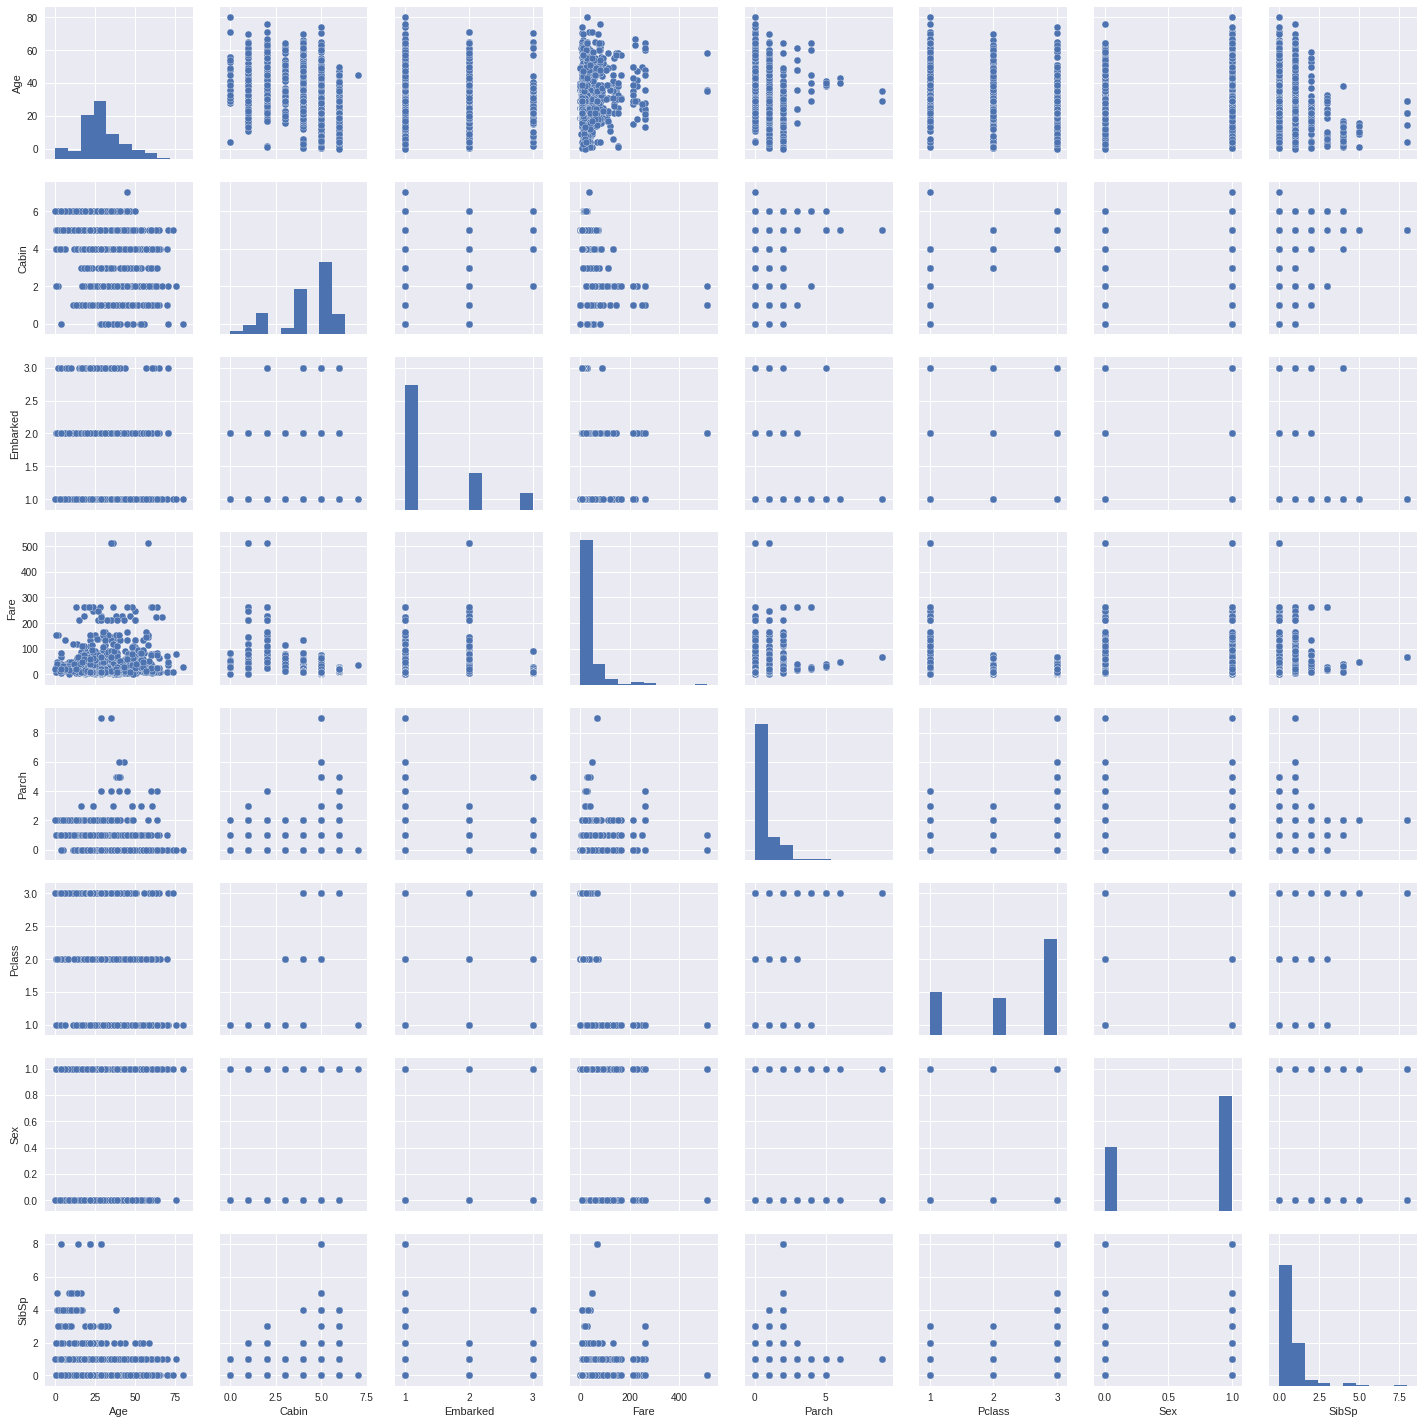

In [51]:
sns.set()
cols = ['Age', 'Cabin', 'Embarked','Fare','Parch','Pclass','Sex','SibSp']
sns.pairplot(full[cols])
plt.show()

In [52]:
#Fit and predict using Logistic Regression
logreg.fit(x_train, y_train)
lg_pred = logreg.predict(x_test)
acc_log = round(logreg.score(x_train, y_train) * 100, 2)
acc_log

82.27

In [53]:
#Fit and predict using Perceptron
perceptron.fit(x_train, y_train)
per_pred = perceptron.predict(x_test)
acc_perceptron = round(perceptron.score(x_train, y_train) * 100, 2)
acc_perceptron

79.91

In [54]:
#Fit and predict using Random Forest
random_forest.fit(x_train, y_train)
rf_pred = random_forest.predict(x_test)
random_forest.score(x_train, y_train)
acc_random_forest = round(random_forest.score(x_train, y_train) * 100, 2)
acc_random_forest

92.03

In [55]:
#Fit and predict using Decision Tree
decision_tree.fit(x_train, y_train)
dt_pred = decision_tree.predict(x_test)
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree

92.03

In [0]:
#Export data to csv files
submission = pd.DataFrame({
        "PassengerId": id_test,
        "Survived": lg_pred
    })
submission.to_csv('submissionlg.csv', index=False)

In [0]:
submission = pd.DataFrame({
        "PassengerId": id_test,
        "Survived": rf_pred
    })
submission.to_csv('submissionrf.csv', index=False)

In [0]:
submission = pd.DataFrame({
        "PassengerId": id_test,
        "Survived": dt_pred
    })
submission.to_csv('submissiondt.csv', index=False)

In [0]:
submission = pd.DataFrame({
        "PassengerId": id_test,
        "Survived": per_pred
    })
submission.to_csv('submissionper.csv', index=False)
#To download these csv files, please uncomment the following code
#from google.colab import files
#files.download('submissionper.csv')

In [0]:
#When applying the models on training set, Decision Tree and Random Forest have the best scores. 
#However, when applying them on the test set, Logistic Regression got the best accuracy. 
#The best score of these four submissions is 0.76076. 